In [1]:
# Dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# Create engine for database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Creating inspector to get table information
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [3]:
# Examining "Measurement" table
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [4]:
# Examining "Station" table
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# Discovering the final date recorded
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")
print(last_date)

2017-08-23 00:00:00


In [6]:
# Creating a date variable for one year prior to the final date recorded
year_ago = last_date - dt.timedelta(days=365)
print(year_ago)

2016-08-23 00:00:00


In [7]:
# Retrieving precipitation data with a range of final date recorded to one year prior
twelve_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
group_by(Measurement.date).all()

In [8]:
# Stores query result in a pandas dataframe
columns = ['date', 'precipitation']
df = pd.DataFrame(twelve_months, columns = columns)
df.set_index('date', inplace = True)
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [9]:
# Summary statistics for query data
df.describe()

,precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


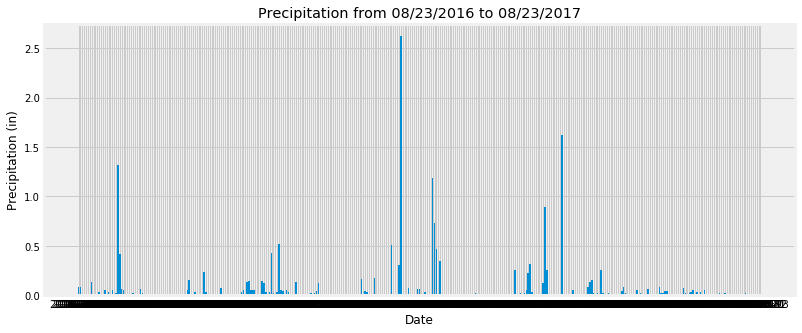

In [10]:
# Precipitation data from the year displayed as a bar graph
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title("Precipitation from 08/23/2016 to 08/23/2017")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (in)")

ax.bar(df.index, df.precipitation)

plt.show()

In [11]:
# Returns the total number of stations in the dataset
total_stations = len(session.query(Station.station).all())

print(f"The total number of stations is: {total_stations}")

The total number of stations is: 9


In [12]:
# Queries a count of measurements done by each station, then saves station name with most frequent measurements.
station_recordings = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_station = station_recordings[0][0]

print(f"The most active station in the data is: {active_station}")

The most active station in the data is: USC00519281


In [13]:
# Retrieves temperature data from the most active station for the year prior to the final date measured.
# Stores query result in a pandas dataframe.
# Summary statistics include what the lowest, highest, and average temperature recorded was.
temp_last_12_mo = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == active_station).\
filter(Measurement.date >= year_ago).all()
columns = ["station", "temperature"]
temp_df = pd.DataFrame(temp_last_12_mo, columns = columns)
temp_df.set_index("station", inplace = True)
temp_df.describe()

,temperature
count,351.000000
mean,73.096866
std,4.735491
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


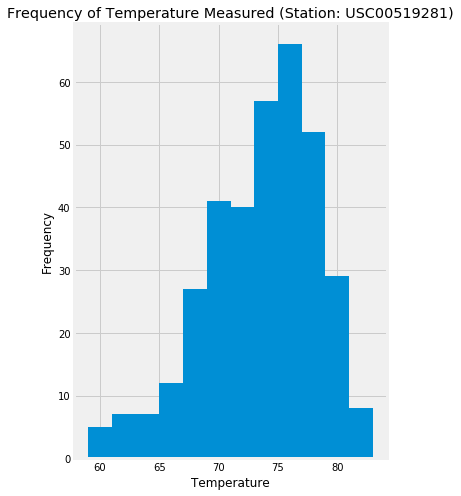

In [14]:
# Temperature data from the previous query displayed as a histogram.
fig, ax = plt.subplots(figsize=(5,8))

ax.set_title("Frequency of Temperature Measured (Station: USC00519281)")
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.hist(temp_df.temperature, bins=12)

plt.show()